# EBA3500 Lecture 7 (i): Categorical data

## What's a categorical variable?
We frequently divide data types into three categories:
1. **Continuous / real-valued / decimal-valued / numeric.** These are `float` or `float64` in Python. A common example is height and weight. Most of our numeric data has been unbounded, i.e., it can take on arbitrarily large or small values. 
2. **Ordered / ordinal data.** This is data equipped with an *order*. For instance, a gold medal is better than a silver medal, and a silver medal is better than a bronze medal. Education level is also ordinal. Having finished high school obviously scores as more education than having finished junior high, but it's unclear by how much. Continuous data is ordered, but not all ordered data is continuous!
3. **Categorical data.** Data with no order that's not naturally associated with a decimal number. Examples include gender, ethnicity, and major in college (sociology, economics, etc.). We often handle ordinal data as categorical data, just because it's easier. Categorical data can often be worked with using `set` objects and the `Counter` function from `itertools`.

Regression with categorical *covariates* is super-important, but is harder conceptually than regression with real-valued covariates. 

We covered regression with categorical *responses* two lectures age, when we talked about logistic regression. In that case we only talked about two categories, however, which is why we called it binary regression. Logistic regression
can be extended to handle both [categorical](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) and [ordinal data](https://en.wikipedia.org/wiki/Ordered_logit), but we won't cover these in this lecture.



### A rough categorization of methods
A rough delineation of the different regression types are in this table, where ANOVA is an abbreviation of "analysis of variance".

| | Response type |   |   |
|-| --------------|-- | - |
|**Covariate type** | Numeric | Categorical or binary | Ordered |
|  Numeric          | Linear regression | (Multivariate) Logistic regression | Ordered logit
| Categorical       | Linear regression / ANOVA| (Multivariate) logistic regression | Ordered logit
| Ordinal           | Constrained linear regression | [Constrained logistic regression](https://en.wikipedia.org/wiki/Constrained_least_squares) | Constrained ordered logit |

**The key message:** It's the response type that primarily determines the regression method, not the covariate type! As we'll see, there is a general method for handling categorical data that can be used in any regression model that supports decimal data. This matters quite a bit, as it allows you to mix and match covariate types in a single model. 

The categorization is rough for two reasons: It doesn't show *every* possibility for handling any of the covariate-response combination. For instance, one may use Probit regression instead of Logistic regrssion. Moreover, it doesn't cover every response type either. Other kinds of responses include numeric data bounded between $0$ and $1$, positive numeric data, and count data. But there exists methods for all these kinds of data as well.

## Linear regression with categorical variables

Let $A$ be a set of categories, for instance $A = \{\textrm{male}, \textrm{female}\}$. Recall the indicator function $1[x\textrm{ in }A]$, which equals $1$ if $x\textrm{ in }A$ and $0$ otherwise.



#### Definition: Categorical regression with one category
> Let $A$ be a set. Then the linear regression model on this set of categories is
$$
y = \sum_{a\in A} \beta_a 1[x\textrm{ = }a] + \epsilon,\quad x \textrm{ in } A.
$$



#### Interpreting the definition. 
We can write the model
$$
y = \sum_{a\in A} \beta_a 1[x\textrm{ = }a] + \epsilon,\quad x \textrm{ in } A.
$$
in a way that might be easier to interpret. Let $x = a'$ for some $a'$ in $A$. By the definition of the indicator function, $1[x\textrm{ = }a] = 0$ for all $a$ in $A$ except for $a'$, where $1[x\textrm{ = }a'] = 1$. Plugging this into the definiton of $y$, we find that $y = \beta_{a'} + \epsilon$. 

For instance, if $a = \textrm{female}$, then $y = \beta_\textrm{female} + \epsilon$.


### Example: Penguins
Let's go back to the penguins example.

In [48]:
import seaborn as sns
penguins = sns.load_dataset("penguins")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


We'll work with the `island` covariate, which is categorical with three categories.

In [ ]:
from collections import Counter
Counter(penguins.island)

Counter({'Biscoe': 168, 'Dream': 124, 'Torgersen': 52})

Using `bill_length_mm` as our numeric response, we may write out a regression model as:

$$
\textrm{bill_length_mm} = \beta_{\textrm{Biscoe}}1[\textrm{island} =\textrm{Biscoe}]+\beta_{\textrm{Dream}}1[\textrm{island} =\textrm{Dream}] + \beta_{\textrm{Torgersen}}1[\textrm{island} =\textrm{Torgersen}] + \epsilon
$$

Running the regression above in `statsmodels` is not too hard. But first, let's plot the data and compute some means!

We can use the `countplot` command to make bar charts for the number of observations in each island.

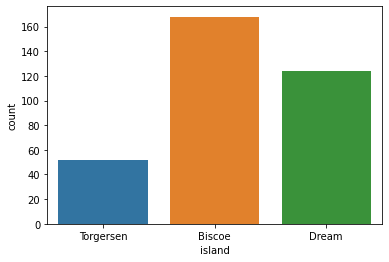

In [ ]:
import seaborn as sns
sns.countplot(x="island", data=penguins)

That's nice and all - but what about the bill lengths at all the islands?

The `groupby` method can be used to calculate summary functions such as the mean. 

In [ ]:
penguins.groupby("island").mean()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
island,,,,
Biscoe,45.257485,15.874850,209.706587,4716.017964
Dream,44.167742,18.344355,193.072581,3712.903226
Torgersen,38.950980,18.429412,191.196078,3706.372549


We find that the bill lengths appear different across island. 

The method `groupby` is not restricted to `mean`, the standard deviation `std` can also be used. You can also define your own functions. 

In [ ]:
penguins.groupby("island").std()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
island,,,,
Biscoe,4.772731,1.820721,14.142268,782.855743
Dream,5.953527,1.133116,7.507366,416.644112
Torgersen,3.025318,1.339447,6.232238,445.107940


Now let's run a regression! Recall the formula,
$$
\textrm{bill_length_mm} = \beta_{\textrm{Biscoe}}1[\textrm{island} =\textrm{Biscoe}]+\beta_{\textrm{Dream}}1[\textrm{island} =\textrm{Dream}] + \beta_{\textrm{Torgersen}}1[\textrm{island} =\textrm{Torgersen}] + \epsilon
$$

Running this is quite easy to do. Just use the formula

`bill_length_mm ~ I(1 * (island == 'Biscoe')) + I(1 * (island == 'Dream')) + I(1 * (island == 'Torgersen')) - 1`. 

1. We write `-1` at the end to remove the intercept from the model. `statsmodels` includes the intercept by default, and writing either `+0` or `-1` will remove it. There is no intercept in the model above, so this is what we want.
2. Remember that `1 * (x = a)` is the vectorized indicator function we went through in the previous lecture.
3. The `I(f(x))` command tells `statsmodels` that it shouldn't try to interpret `f(x)`. You also had to use it in e.g. `I(x**2)` in the quadratic regression model.)

In [49]:
import statsmodels.formula.api as smf

In [50]:
fit = smf.ols("bill_length_mm ~ I(1 * (island == 'Biscoe')) + I(1 * (island == 'Dream')) + I(1 * (island == 'Torgersen')) - 1", data = penguins).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         bill_length_mm   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     30.86
Date:                Thu, 07 Oct 2021   Prob (F-statistic):           4.86e-13
Time:                        09:13:04   Log-Likelihood:                -1036.7
No. Observations:                 342   AIC:                             2079.
Df Residuals:                     339   BIC:                             2091.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
I(1 * (island == 'Biscoe'))       45.2575      0.390    116.127      0.000      44.491      46.024
I(1 * (island == 'Dream'))        44.1677      0.452     97.657      0.000      43.278      45.057
I(1 * (island == 'Torgersen'))    38.9510      0.705     55.232      0.000      37.564      40.338
==============================================================================
Omnibus:                        8.214   Durbin-Watson:                   0.978
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                4.722
Skew:                          -0.064   Prob(JB):                       0.0943
Kurtosis:                       2.439   Cond. No.                         1.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

However, you don't need to do all this, as statsmodels can do it for you. To use a column `x` in a data frame as a categorical variable, use `C(x)` in the formula, e.g. `y ~ C(x)`. You often don't have to do this either, if `x` is already categorical. But it's a nice habbit.

When you use `C(x)`, statsmodels will expand the term into its categorical regression form automatically. It will do this expansion in a way that includes the intercept, however. To avoid this, you need to write `C(x) - 1`.

In [ ]:
fit = smf.ols("bill_length_mm ~ C(island) - 1", data = penguins).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         bill_length_mm   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     30.86
Date:                Thu, 30 Sep 2021   Prob (F-statistic):           4.86e-13
Time:                        05:01:00   Log-Likelihood:                -1036.7
No. Observations:                 342   AIC:                             2079.
Df Residuals:                     339   BIC:                             2091.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(island)[Biscoe]       45.2575      0.390    116.127      0.000      44.491      46.024
C(island)[Dream]        44.1677      0.452     97.657      0.000      43.278      45.057
C(island)[Torgersen]    38.9510      0.705     55.232      0.000      37.564      40.338
==============================================================================
Omnibus:                        8.214   Durbin-Watson:                   0.978
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                4.722
Skew:                          -0.064   Prob(JB):                       0.0943
Kurtosis:                       2.439   Cond. No.                         1.81
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

These results are the same, just as we wanted.

Also note that the estimated beta coefficients are exactly the same as the means we just calculated. This is true in general.

The rôle of "-1" in "bill_length_mm ~ C(island) - 1" is to remove the intercept from the regression model. We often do not want to this, as it makes it hard to look at the the *p*-values. 

In [ ]:
fit.pvalues

C(island)[Biscoe]       4.681012e-275
C(island)[Dream]        2.708558e-250
C(island)[Torgersen]    1.475592e-171
dtype: float64

Here we see that all of the beta coefficients are highly significant. But what does that mean? It means that the mean length of the bills are unlikely to be $0$ for every island! What we typically care about is whether there is a difference between the islands, say Biscoe and Dream. 

In [ ]:
fit2 = smf.ols("bill_length_mm ~ C(island)", data = penguins).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         bill_length_mm   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     30.86
Date:                Thu, 30 Sep 2021   Prob (F-statistic):           4.86e-13
Time:                        05:01:12   Log-Likelihood:                -1036.7
No. Observations:                 342   AIC:                             2079.
Df Residuals:                     339   BIC:                             2091.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 45.2575      0.390    116.127      0.000      44.491      46.024
C(island)[T.Dream]        -1.0897      0.597     -1.825      0.069      -2.264       0.085
C(island)[T.Torgersen]    -6.3065      0.806     -7.827      0.000      -7.891      -4.722
==============================================================================
Omnibus:                        8.214   Durbin-Watson:                   0.978
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                4.722
Skew:                          -0.064   Prob(JB):                       0.0943
Kurtosis:                       2.439   Cond. No.                         3.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this run of the regression model, there is no `C(island)[Biscoe]` because this coefficient has been absorbed into a *baseline*. 

Our first model was
$$
\textrm{bill_length_mm} = \beta_{\textrm{Biscoe}}1[\textrm{island} =\textrm{Biscoe}]+\beta_{\textrm{Dream}}1[\textrm{island} =\textrm{Dream}] + \beta_{\textrm{Torgersen}}1[\textrm{island} =\textrm{Torgersen}] + \epsilon
$$



But now our model is
$$
\textrm{bill_length_mm} = \beta_0 +\beta^*_{\textrm{Dream}}1[\textrm{island} =\textrm{Dream}] + \beta^*_{\textrm{Torgersen}}1[\textrm{island} =\textrm{Torgersen}] + \epsilon
$$

When `island = Biscoe`, only $\beta_0$ is kept. Hence the intercept of `fit2` equals the Biscoe coeffcient of `fit1`.

In [ ]:
fit.params

C(island)[Biscoe]       45.257485
C(island)[Dream]        44.167742
C(island)[Torgersen]    38.950980
dtype: float64

In [ ]:
fit2.params

Intercept                 45.257485
C(island)[T.Dream]        -1.089743
C(island)[T.Torgersen]    -6.306505
dtype: float64

The other parameters do not match, but they shouldn't, as the first model contains no intercept! To match them, we must look at what happens when, e.g., `island = Dream` in both models. 

In the first model, $y = \beta_{\textrm{Dream}} + \epsilon$ when `island = Dream`. In the second model, 
$$
\textrm{bill_length_mm} = \beta_0 +\beta^*_{\textrm{Dream}}1[\textrm{island} =\textrm{Dream}] + \beta^*_{\textrm{Torgersen}}1[\textrm{island} =\textrm{Torgersen}] + \epsilon
$$
We find that 
$$
\textrm{bill_length_mm} = \beta_0 +\beta^*_{\textrm{Dream}}1[\textrm{island}] + \epsilon
$$
hence we need to add the intercept to $\beta^*_{\textrm{Dream}}$ in order to recover $\beta_{\textrm{Dream}}$

In [ ]:
fit2.params[0] + fit2.params[1]

44.16774193548389

In [ ]:
fit.params[1]

44.16774193548388

## Summary
1. There are roughly three kinds of data: Decimal, ordinal, and categorical.
3. The interpretation of categories variables in a regression model uses the indicator function: $$
y = \sum_{a\in A} \beta_a 1[x\textrm{ = }a] + \epsilon,\quad x \textrm{ in } A.
$$
3. `statsmodels` automatically fits a regression model of the kind above when given categorical covariates.